In [1]:
%load_ext autoreload
%autoreload 2
# import pandas as pd
import scripts.config as cfg
from os.path import join
from analysis_settings import *
from plot_settings import *
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils_plot import _add_band, _add_band_annotations, convert_pvalue_to_asterisks
# from scripts.cluster_stats import lineplot_compare, _pval_correction_lineplot
from scripts.utils_plot import _save_fig, plot_corrs, _axes2d
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
from scipy.stats import wilcoxon
# from matplotlib.lines import Line2D
# from pte_stats import cluster, timeseries
# from matplotlib.ticker import FuncFormatter
# from matplotlib.patches import Patch

In [2]:
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)
df = dataframes['df_per']
df = df[~df.project.isin(['all'])]
# df = df[df.asymmetric_subjects]
# remove subjects without fooof
# df = df[df.fm_exponent > -1e9]
# df = df[df.cond.isin(['off', 'on'])]
# df = df[df.cond.isin(['off']) | (df.cond.isin(['on']) & df.dominant_side_consistent_or_equal)]
df_all = df[df.cond.isin(['off', 'on'])]
df = df[df.cond.isin(['off']) | (df.cond.isin(['on']) & df.dominant_side_consistent)]

severity = ['severe side', 'mild side']

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

# Plot proabability of peaks

In [3]:
# conds  = ['off', 'on']
# bands = ['beta_low', 'beta_high', 'gamma']
# n_rows = len(conds)
# n_col = len(bands)

# y = 'fm_peak_count'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 1.3*n_rows), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# for row, cond in enumerate(conds):

#     col = f"patient_symptom_dominant_side_BR_{cond}"

#     df_mild = df[(df[col] == 'mild side') & (df.cond == cond)]
#     df_severe = df[(df[col] == 'severe side') & (df.cond == cond)]

#     axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
#     for col, band in enumerate(bands):
#         mild_percentage = (df_mild[f'{band}_{y}'] > 0).sum() / len(df_mild) * 100
#         severe_percentage = (df_severe[f'{band}_{y}'] > 0).sum() / len(df_severe) * 100
#         ax = axes[row, col]
#         kind = 'periodic' if row == 0 else 'periodic2'
#         ax.bar(1, severe_percentage, color=cfg.COLOR_DIC[kind])
#         ax.bar(2, mild_percentage, color=cfg.COLOR_DIC[kind])
#         # ax.set_ylabel(None)
#         ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
#         if row == 0:
#             ax.set_title(f'Has {cfg.BAND_NAMES_GREEK_SHORT[band]} peak')
#         ax.set_xticks([1, 2], ['Severe', 'Mild'])
#     # plt.suptitle(cond)
# fig.supxlabel('Hemisphere')
# plt.tight_layout()
# _save_fig(fig, f'{'_'.join(bands)}_{y}_{'_'.join(conds)}', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

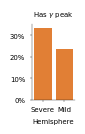

In [4]:
# for cond in ['on', 'off']:
y = 'fm_peak_count'
for cond in ['on']:
    col = f"patient_symptom_dominant_side_BR_{cond}"

    df_mild = df[(df[col] == 'mild side') & (df.cond == cond)]
    df_severe = df[(df[col] == 'severe side') & (df.cond == cond)]

    bands = [
        # 'beta',
            # 'beta_low', 'beta_high',
            # 'gamma_low', 'gamma_mid1',
            'gamma']
    n_col = len(bands)
    fig, axes = plt.subplots(1, n_col, figsize=(.8*n_col, 1.3), sharey=False)
    axes = _axes2d(axes, 1, n_col)
    for i, band in enumerate(bands):
        mild_percentage = (df_mild[f'{band}_{y}'] > 0).sum() / len(df_mild) * 100
        severe_percentage = (df_severe[f'{band}_{y}'] > 0).sum() / len(df_severe) * 100
        ax = axes[0, i]
        kind = 'periodic' if i == 0 else 'periodic2'
        ax.bar(1, severe_percentage, color=cfg.COLOR_DIC['periodic2'])
        ax.bar(2, mild_percentage, color=cfg.COLOR_DIC['periodic2'])
        ax.set_ylabel(None)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax.set_title(f'Has {cfg.BAND_NAMES_GREEK_SHORT[band]} peak')
        ax.set_xticks([1, 2], ['Severe', 'Mild'])
        ax.set_xlabel('Hemisphere')
    # plt.suptitle(cond)
    plt.tight_layout()
    _save_fig(fig, f'{'_'.join(bands)}_{y}_{cond}', close=False, bbox_inches=None,
              transparent=True,
            save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

# Plot power by hemisphere


In [5]:
def stat_anno(ax, df, x, y, groupby='subject', alternative='two-sided'):
    ymin, ymax = ax.get_ylim()
    yscale = np.abs(ymax - ymin)
    y_buffer = 0.1*yscale

        # Draw the line connecting the two bars
    x1, x2 = ax.get_xticks()
    y_line = ymax + y_buffer
    ax.plot([x1, x1, x2, x2],
                [y_line, y_line + y_buffer/2, y_line + y_buffer/2, y_line],
                color='black')

    # Get the significance text based on the p-value
    vals = df.copy().sort_values([groupby, x]).groupby(groupby)[y]
    xy_diff = vals.diff().dropna()
    pvalue = wilcoxon(xy_diff, alternative=alternative)[1]
    print(pvalue)
    text = convert_pvalue_to_asterisks(pvalue, print_ns=True)

    # Place the text above the line
    y_text = y_line + y_buffer/2  # Add a little more offset for the asterisks
    ax.text((x1 + x2) / 2, y_text, text,
                ha='center', va='bottom', fontsize=FONTSIZE_ASTERISK)

    ax.set_ylim([ymin-y_buffer, ymax+4*y_buffer])

In [6]:
# conds  = ['off', 'on']
# yvals = ['beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log', 'gamma_fm_powers_max_log',
#          'full_fm_band_aperiodic_log']
# n_rows = len(conds)
# n_col = len(yvals)

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 1*n_rows), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# for row, cond in enumerate(conds):

#     x = f"patient_symptom_dominant_side_BR_{cond}"

#     df_plot = df[(df.cond == cond)]

#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#         kind = 'periodic' if row == 0 else 'periodic2'
#         sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       errorbar=('ci', 95), order=severity)
#         stat_anno(ax, df_plot, x, y)

#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xticks([0, 1], ['More', 'Less'])
#         ax.set_xlim(-.5, 1.5)
#     axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Power [log($\mu$V$^2/Hz$)]')
# plt.tight_layout()
# _save_fig(fig, f'{'_'.join(bands)}_{y}_{'_'.join(conds)}_severity', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [7]:
# conds  = ['off', 'on']
# yvals = ['beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log', 'gamma_fm_powers_max_log']
# n_rows = 1
# row = 0
# n_col = len(yvals)

# pwr = 'fm_powers_max_log'

# for cond in conds:
#     df_plot = df[(df.cond == cond)]

#     fig, axes = plt.subplots(n_rows, n_col, figsize=(2, .7), sharey=False, sharex=True)
#     axes = _axes2d(axes, n_rows, n_col)

#     x = f"patient_symptom_dominant_side_BR_{cond}"


#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         kind = 'periodic' if cond == 'off' else 'periodic2'
#         sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       errorbar=('ci', 95), order=severity)
#         stat_anno(ax, df_plot, x, y)

#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y].replace(' Peak', ''))
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xticks([0, 1], ['More', 'Less'])
#         ax.set_xlim(-.5, 1.5)
#     # axes[row, 0].set_ylabel(r'Power [log($\mu$V$^2/Hz$)]')
#     plt.tight_layout()
#     _save_fig(fig, f'{'_'.join(bands)}_{y}_{cond}_severity', close=False, bbox_inches=None,
#                 transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [8]:
# conds  = ['off', 'on']
# yvals = ['fm_exponent', 'fm_offset_log', 'full_fm_band_aperiodic_log']
# n_rows = 1
# row = 0
# n_col = len(yvals)

# pwr = 'fm_powers_max_log'

# for cond in conds:
#     df_plot = df[(df.cond == cond)]

#     fig, axes = plt.subplots(n_rows, n_col, figsize=(2, .7), sharey=False, sharex=True)
#     axes = _axes2d(axes, n_rows, n_col)

#     x = f"patient_symptom_dominant_side_BR_{cond}"


#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         kind = 'periodicAP' if cond == 'off' else 'periodicAP2'
#         sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       errorbar=('ci', 95), order=severity)
#         stat_anno(ax, df_plot, x, y)

#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y].replace(' Peak', ''))
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xticks([0, 1], ['More', 'Less'])
#         ax.set_xlim(-.5, 1.5)
#     # axes[row, 0].set_ylabel(r'Power [log($\mu$V$^2/Hz$)]')
#     plt.tight_layout()
#     _save_fig(fig, f'{'_'.join(bands)}_{y}_{cond}_severity', close=False, bbox_inches=None,
#                 transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [9]:
# conds  = ['off', 'on']
# severity = ['severe side', 'mild side']
# yvals = ['beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log', 'gamma_fm_powers_max_log',
#          'full_fm_band_aperiodic_log']
# n_rows = 1
# n_col = len(yvals)
# x = 'cond'
# pwr = 'fm_powers_max_log'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 1*n_rows),
#                          sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)

# row = 0
# # for row, more_less in enumerate(severity):

# hemi = f"patient_symptom_dominant_side_BR_{cond}"

# # df_plot = df[(df[hemi] == more_less)]
# df_plot = df

# for col, y in enumerate(yvals):
#     ax = axes[row, col]
#     # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#     kind = 'periodic' if row == 0 else 'periodic2'
#     sns.pointplot(df_plot, y=y, hue=x, ax=ax, x=hemi,
#                   palette=[cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind+'2']],
#                   hue_order=conds, legend=False,
#                   errorbar=('ci', 95))

#     stat_anno(ax, df_plot, x, y)
#     if row == 0:
#         ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#     ax.set_ylabel(None)
#     ax.set_xlabel(None)
#     ax.set_xlim(-.5, 1.5)

# axes[row, 0].set_ylabel(severity[row])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Power [log($\mu$V$^2/Hz$)]')
# plt.tight_layout()
# _save_fig(fig, f'{'_'.join(bands)}_{y}_{'_'.join(conds)}_severity2', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

# Check by condition

In [10]:
# conds  = ['off', 'on']
# yvals = ['beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log', 'gamma_fm_powers_max_log',
#          'full_fm_band_aperiodic_log',
#          'fm_offset_log', 'fm_exponent']
# n_rows = 1
# n_col = len(yvals)
# x = 'cond'
# pwr = 'fm_powers_max_log'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 1*n_rows), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# row = 0
# for col, y in enumerate(yvals):
#     ax = axes[row, col]
#     # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#     kind = 'periodic' #if row == 0 else 'periodic2'
#     if not 'powers' in y:
#         kind = 'periodicAP'
#     sns.pointplot(df, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                   errorbar=('ci', 95), order=conds)
#     # for sub_hemi in df.sub_hemi.unique():
#     #     sns.pointplot(df[df.sub_hemi.isin([sub_hemi])], y=y, x=x, ax=ax, lw=.01)
#     stat_anno(ax, df, x, y, groupby='sub_hemi')

#     if row == 0:
#         ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#     ax.set_ylabel(None)
#     ax.set_xlabel(None)
#     ax.set_xlim(-.5, 1.5)
#     # ax.set_xticks([0, 1], ['More', 'Less'])
# # axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
# # fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Power [log($\mu$V$^2/Hz$)]')
# plt.tight_layout()
# _save_fig(fig, f'{'_'.join(bands)}_{y}_by_cond', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [11]:
# conds  = ['off', 'on']
# severity = ['severe side', 'mild side']
# yvals = ['beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log', 'gamma_fm_powers_max_log',
#          'full_fm_band_aperiodic_log']
# n_rows = len(conds)
# n_col = len(yvals)
# x = 'cond'
# pwr = 'fm_powers_max_log'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 1*n_rows),
#                          sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)


# for row, more_less in enumerate(severity):

#     hemi = f"patient_symptom_dominant_side_BR_{cond}"

#     df_plot = df[(df[hemi] == more_less)]

#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#         kind = 'periodic' if row == 0 else 'periodic2'
#         sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       errorbar=('ci', 95), order=conds)

#         stat_anno(ax, df_plot, x, y)
#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xlim(-.5, 1.5)

#     axes[row, 0].set_ylabel(severity[row])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Power [log($\mu$V$^2/Hz$)]')
# plt.tight_layout()
# _save_fig(fig, f'{'_'.join(bands)}_{y}_severity_cond', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [12]:
# conds  = ['off', 'on']
# severity = ['severe side', 'mild side']
# yvals = ['beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log', 'gamma_fm_powers_max_log',
#          'full_fm_band_aperiodic_log']
# n_rows = 1
# n_col = len(yvals)
# x = 'cond'
# pwr = 'fm_powers_max_log'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 1*n_rows),
#                          sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)

# row = 0
# # for row, more_less in enumerate(severity):

# hemi = f"patient_symptom_dominant_side_BR_{cond}"

# # df_plot = df[(df[hemi] == more_less)]
# df_plot = df

# for col, y in enumerate(yvals):
#     ax = axes[row, col]
#     # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#     kind = 'periodic' if row == 0 else 'periodic2'
#     sns.pointplot(df_plot, y=y, x=x, ax=ax, hue=hemi,
#                   palette=[cfg.COLOR_DIC[kind], cfg.COLOR_DIC[kind]],
#                   hue_order=severity, legend=False,
#                   errorbar=('ci', 95), ls=['-', '--'])

#     stat_anno(ax, df_plot, x, y)
#     if row == 0:
#         ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#     ax.set_ylabel(None)
#     ax.set_xlabel(None)
#     ax.set_xlim(-.5, 1.5)

# axes[row, 0].set_ylabel(severity[row])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Power [log($\mu$V$^2/Hz$)]')
# plt.tight_layout()

# Reproduce Shreve 2017

"The conservative peak detection algorithm identified a peak in the 8–35 Hz frequency range across one of the electrode pairs of the STN DBS lead in all but one (129/130) case. If the peak analysis was restricted to the bipolar recording with maximum absolute 8–35 Hz power, peaks were evident in 125/130 recordings."

My finding: 96%

In [13]:
# conds  = ['off', 'on']
# bands = ['alpha_beta']
# n_rows = len(conds)
# n_col = len(bands)

# y = 'fm_peak_count'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(2, 2), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# for row, cond in enumerate(conds):

#     col = f"patient_symptom_dominant_side_BR_{cond}"

#     df_mild = df[(df[col] == 'mild side') & (df.cond == cond)]
#     df_severe = df[(df[col] == 'severe side') & (df.cond == cond)]
#     df_either = df[(df.cond == cond)]

#     axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
#     for col, band in enumerate(bands):
#         mild_percentage = (df_mild[f'{band}_{y}'] > 0).sum() / len(df_mild) * 100
#         severe_percentage = (df_severe[f'{band}_{y}'] > 0).sum() / len(df_severe) * 100
#         either_percentage = (df_either[f'{band}_{y}'] > 0).sum() / len(df_either) * 100
#         ax = axes[row, col]
#         kind = 'periodic' if row == 0 else 'periodic2'
#         ax.bar(1, severe_percentage, color=cfg.COLOR_DIC[kind])
#         ax.bar(2, mild_percentage, color=cfg.COLOR_DIC[kind])
#         ax.bar(3, either_percentage, color=cfg.COLOR_DIC[kind])
#         print(f'Peak in either hemisphere: {either_percentage:.2f}%')
#         # ax.set_ylabel(None)
#         ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
#         if row == 0:
#             ax.set_title(f'Has {cfg.BAND_NAMES_GREEK_SHORT[band]} peak')
#         ax.set_xticks([1, 2, 3], ['Severe', 'Mild', 'Either'])
#     # plt.suptitle(cond)
# fig.supxlabel('Hemisphere')
# plt.tight_layout()
# # _save_fig(fig, f'{'_'.join(bands)}_{y}_{'_'.join(conds)}', close=False, bbox_inches=None,
# #             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

Peak in either hemisphere off: 0.95%
Peak in either hemisphere off: 0.86%
Peak in either hemisphere on: 0.95%
Peak in either hemisphere on: 0.86%


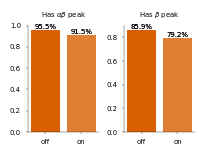

In [14]:
conds  = ['off', 'on']
bands = ['alpha_beta', 'beta']
n_rows = 1  # len(conds)
n_col = len(bands)

y = 'fm_peak_count'

fig, axes = plt.subplots(n_rows, n_col, figsize=(2, 1.5))
axes = _axes2d(axes, n_rows, n_col)
row = 0
for cond in conds:

    col = f"patient_symptom_dominant_side_BR_{cond}"

    df_off = df[(df.cond == 'off')]
    df_on = df[(df.cond == 'on')]

    for col, band in enumerate(bands):
        off_percentage = (df_off[f'{band}_{y}'] > 0).sum() / len(df_off) # * 100
        on_percentage = (df_on[f'{band}_{y}'] > 0).sum() / len(df_on) # * 100
        ax = axes[row, col]
        bar1 = ax.bar(1, off_percentage, color=cfg.COLOR_DIC['periodic'])
        bar2 = ax.bar(2, on_percentage, color=cfg.COLOR_DIC['periodic2'])
        ax.bar_label(bar1, fmt='{:.1%}')
        ax.bar_label(bar2, fmt='{:.1%}')
        print(f'Peak in either hemisphere {cond}: {off_percentage:.2f}%')
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        if row == 0:
            ax.set_title(f'Has {cfg.BAND_NAMES_GREEK_SHORT[band]} peak')
        ax.set_xticks([1, 2], ['off', 'on'])
    # plt.suptitle(cond)
# fig.supxlabel('Hemisphere')
plt.tight_layout()
_save_fig(fig, 'reproduce_shreve_fittedPeaks', close=False, bbox_inches=None,
            transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [15]:
# same channel choice as Shreve:

df_all = pd.read_pickle(join('..', cfg.DF_PATH, cfg.DF_FOOOF))
df_all = df_all[~df_all.project.isin(['all']) & (df_all.fm_params == False) & ~df_all.ch_bad
                 & (df_all.psd_kind == "normalized")]
# df = df[df.dominant_side_consistent]
df_all = df_all[df_all.patient_symptom_dominant_side_BR_off.isin(['severe side', 'mild side'])]

# # remove subjects without fooof
df_all = df_all[df_all.cond.isin(['off', 'on'])]
df_all = df_all[df_all.ch_chmax_alpha_beta_abs_max_log & ~df_all.ch_bip_distant]

df_all_abs = pd.read_pickle(join('..', cfg.DF_PATH, cfg.DF_FOOOF))
df_all_abs = df_all_abs[~df_all_abs.project.isin(['all']) & (df_all_abs.fm_params == 'broad') & ~df_all_abs.ch_bad
                 & (df_all_abs.psd_kind == "standard")]
df_all_abs = df_all_abs[df_all_abs.patient_symptom_dominant_side_BR_off.isin(['severe side', 'mild side'])]
# # remove subjects without fooof
df_all_abs = df_all_abs[df_all_abs.cond.isin(['off', 'on'])]
df_all_abs = df_all_abs[df_all_abs.ch_chmax_alpha_beta_abs_max_log & ~df_all_abs.ch_bip_distant]
assert (df_all_abs.subject.value_counts() <= 4).all()

0.00773432376851444
0.01304159840718316
0.004316592502516329
0.003873818592127736
0.011357516130193222
0.10863603670794571
0.23109782508249832
0.3300207449366509
0.12323750280549874
0.040239567250506765


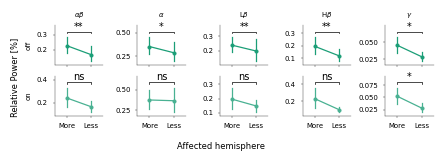

In [16]:
conds  = ['off', 'on']
# conds  = ['off']
# yvals = ['alpha_beta_abs_max', 'alpha_abs_max',
#         #  'beta_abs_max',
#          'beta_low_abs_max', 'beta_high_abs_max',
#          'gamma_abs_max'
#          ]
yvals = ['alpha_beta_abs_mean', 'alpha_abs_mean',
        #  'beta_abs_max',
         'beta_low_abs_mean', 'beta_high_abs_mean',
         'gamma_abs_mean'
         ]
n_rows = len(conds)
n_col = len(yvals)


fig, axes = plt.subplots(n_rows, n_col, figsize=(4.4, 1.5), sharey=False, sharex=True)
axes = _axes2d(axes, n_rows, n_col)
for row, cond in enumerate(conds):

    x = f"patient_symptom_dominant_side_BR_{cond}"
    # x = f"patient_symptom_dominant_side_BRT_{cond}"

    # df_plot = df_all[(df_all.cond == cond)]
    # df_plot = df[(df.cond == cond)]
    df_plot = df_all_abs[(df_all_abs.cond == cond)]

    for col, y in enumerate(yvals):
        ax = axes[row, col]
        # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
        kind = 'normalized' if row == 0 else 'normalized2'
        sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
                      order=severity,
                      errorbar=('ci', 95))
                    #   errorbar=('se', 1))
        stat_anno(ax, df_plot, x, y,
                #   alternative='less'
                  )

        if row == 0:
            ax.set_title(cfg.PLOT_LABELS_SHORT[y].replace(' mean', ''))
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_xticks([0, 1], ['More', 'Less'])
        ax.set_xlim(-.5, 1.5)
    axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
fig.supxlabel('Affected hemisphere')
fig.supylabel(r'Relative Power [%]')
plt.tight_layout()
_save_fig(fig, f'reproduce_shreve_relative', close=False, bbox_inches=None,
            transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))



# Log runreasnable for relative:

# fig, axes = plt.subplots(n_rows, n_col, figsize=(2*n_col, 2), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# for row, cond in enumerate(conds):

#     x = f"patient_symptom_dominant_side_BR_{cond}"

#     df_plot = df_all[(df_all.cond == cond)]

#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#         kind = 'normalized' if row == 0 else 'normalized2'
#         sns.pointplot(df_plot, y=y+'_log', x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       order=severity,
#                     #   errorbar=('ci', 95))
#                       errorbar=('se', 1))
#         stat_anno(ax, df_plot, x, y,
#                 #   alternative='less'
#                   )

#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xticks([0, 1], ['More', 'Less'])
#         ax.set_xlim(-.5, 1.5)
#     axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Relative Power [log(%)]')
# plt.tight_layout()
# # _save_fig(fig, f'relative_{'_'.join(bands)}_{y}_{'_'.join(conds)}_severity', close=False, bbox_inches=None,
# #             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [17]:
# yvals = ['alpha_beta_abs_max_log', 'alpha_abs_max_log',
#         #  'beta_abs_max_log',
#          'beta_low_abs_max_log', 'beta_high_abs_max_log', 'gamma_abs_max_log']
# n_col = len(yvals)

# fig, axes = plt.subplots(n_rows, n_col, figsize=(.8*n_col, 2), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# for row, cond in enumerate(conds):

#     x = f"patient_symptom_dominant_side_BR_{cond}"

#     # df_plot = df_all_abs[(df_all_abs.cond == cond)]
#     df_plot = df[(df.cond == cond)]

#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#         kind = 'absolute' if row == 0 else 'absolute2'
#         sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       order=severity,
#                       errorbar=('ci', 95))
#                     #   errorbar=('se', 1))
#         stat_anno(ax, df_plot, x, y,
#                 #   alternative='greater'
#                   )

#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xticks([0, 1], ['More', 'Less'])
#         ax.set_xlim(-.5, 1.5)
#     axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Abs. Power [[log($\mu$V$^2/Hz$)]')
# plt.tight_layout()
# _save_fig(fig, f'reproduce_shreve_absolute', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

0.18358404233026326
0.9972151573275685
0.9944303485801911


0.14362302543515776
0.7507759553623083
0.0053486262133251765
0.4531696623928383
0.4397468534643849
0.9821680753024111
0.22956267960461219
0.18470849920123555
0.014689836732543426


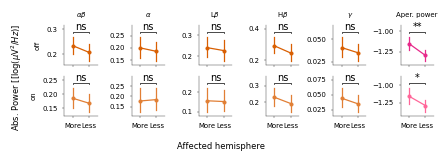

In [18]:
# yvals = ['alpha_beta_fm_powers_max_log', 'alpha_fm_powers_max_log',
#         #  'beta_fm_powers_max_log',
#          'beta_low_fm_powers_max_log', 'beta_high_fm_powers_max_log',
#          'gamma_fm_powers_max_log', 'full_fm_band_aperiodic_log']
yvals = ['alpha_beta_fm_mean_log', 'alpha_fm_mean_log',
        #  'beta_fm_powers_max_log',
         'beta_low_fm_mean_log', 'beta_high_fm_mean_log',
         'gamma_fm_mean_log', 'full_fm_band_aperiodic_log']
n_col = len(yvals)

fig, axes = plt.subplots(n_rows, n_col, figsize=(4.4, 1.5), sharey=False, sharex=True)
axes = _axes2d(axes, n_rows, n_col)
for row, cond in enumerate(conds):

    x = f"patient_symptom_dominant_side_BR_{cond}"

    df_plot = df[(df.cond == cond)]
    # df_plot = df_all_abs[(df_all_abs.cond == cond)]

    for col, y in enumerate(yvals):
        ax = axes[row, col]
        # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
        if 'aperiodic' in y:
            kind = 'periodicAP'
        else:
            kind = 'periodic'
        if row == 1:
            kind += '2'
        sns.pointplot(df_plot, y=y, x=x, ax=ax, color=cfg.COLOR_DIC[kind],
                      order=severity,
                      errorbar=('ci', 95))
                    #   errorbar=('se', 1))
        stat_anno(ax, df_plot, x, y,
                #   alternative='greater'
                  )

        if row == 0:
            ax.set_title(cfg.PLOT_LABELS_SHORT[y].replace(' mean', ''))
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_xticks([0, 1], ['More', 'Less'])
        ax.set_xlim(-.5, 1.5)
    axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
fig.supxlabel('Affected hemisphere')
fig.supylabel(r'Abs. Power [[log($\mu$V$^2/Hz$)]')
plt.tight_layout()
_save_fig(fig, f'reproduce_shreve_periodic', close=False, bbox_inches=None,
            transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [19]:
# yvals = ['alpha_beta_abs_max_log', 'alpha_abs_max_log', 'beta_abs_max_log', 'beta_low_abs_max_log', 'beta_high_abs_max_log', 'gamma_low_abs_max_log']


# fig, axes = plt.subplots(n_rows, n_col, figsize=(1*n_col, 2), sharey=False, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# for row, cond in enumerate(conds):

#     x = f"patient_symptom_dominant_side_BR_{cond}"

#     df_plot = df[(df.cond == cond)]

#     for col, y in enumerate(yvals):
#         ax = axes[row, col]
#         # sns.stripplot(df_cond, y=y, x=hemi, ax=ax, size=1)
#         kind = 'periodic' if row == 0 else 'periodic2'
#         sns.pointplot(df_plot, y=y.replace('_log', ''), x=x, ax=ax, color=cfg.COLOR_DIC[kind],
#                       order=severity,
#                     #   errorbar=('ci', 95))
#                       errorbar=('se', 1))
#         stat_anno(ax, df_plot, x, y,
#                 #   alternative='greater'
#                   )

#         if row == 0:
#             ax.set_title(cfg.PLOT_LABELS_SHORT[y])
#         ax.set_ylabel(None)
#         ax.set_xlabel(None)
#         ax.set_xticks([0, 1], ['More', 'Less'])
#         ax.set_xlim(-.5, 1.5)
#     axes[row, 0].set_ylabel(cfg.COND_DICT[cond])
# fig.supxlabel('Affected hemisphere')
# fig.supylabel(r'Abs. Power [[log($\mu$V$^2/Hz$)]')
# plt.tight_layout()
# _save_fig(fig, f'relative_{'_'.join(bands)}_{y}_{'_'.join(conds)}_severity', close=False, bbox_inches=None,
#             transparent=True, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

### For Huiling

In [20]:
# conds  = ['off', 'on']
# bands = ['alpha_beta', 'beta', 'beta_low', 'beta_high']
# n_rows = 1  # len(conds)
# n_col = len(bands)

# y = 'fm_peak_count'

# fig, axes = plt.subplots(n_rows, n_col, figsize=(4, 1.5), sharey=True, sharex=True)
# axes = _axes2d(axes, n_rows, n_col)
# row = 0
# for cond in conds:

#     col = f"patient_symptom_dominant_side_BR_{cond}"

#     df_off = df_all[(df_all.cond == 'off')]
#     df_on = df_all[(df_all.cond == 'on')]

#     for col, band in enumerate(bands):
#         off_percentage = (df_off[f'{band}_{y}'] > 0).sum() / len(df_off) # * 100
#         on_percentage = (df_on[f'{band}_{y}'] > 0).sum() / len(df_on) # * 100
#         ax = axes[row, col]
#         bar1 = ax.bar(1, off_percentage, color=cfg.COLOR_DIC['periodic'])
#         bar2 = ax.bar(2, on_percentage, color=cfg.COLOR_DIC['periodic2'])
#         ax.bar_label(bar1, fmt='{:.1%}')
#         ax.bar_label(bar2, fmt='{:.1%}')
#         print(f'Peak in either hemisphere {cond}: {off_percentage:.2f}%')
#         # ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
#         if row == 0:
#             ax.set_title(f'Has {cfg.BAND_NAMES_GREEK[band]} peak')
#         ax.set_xticks([1, 2], ['off', 'on'])
#     # plt.suptitle(cond)
# fig.suptitle(f'Hemispheres off: {df_off.shape[0]}, on: {df_on.shape[0]}')
# plt.tight_layout()
# _save_fig(fig, 'for_huiling', close=False, bbox_inches=None,
#             transparent=False, save_dir=join(SAVE_DIR, 'Figure5', ch_choice))

In [21]:
(df_off.sub_hemi.value_counts() <= 1).all()

np.True_

# Supplementary Adjacent

In [22]:
ch_choice = 'ch_adj_beta_high_max_off'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)
df = dataframes['df_per']
df = df[~df.project.isin(['all'])]
df_all = df[df.cond.isin(['off', 'on'])]
df = df[df.cond.isin(['off']) | (df.cond.isin(['on']) & df.dominant_side_consistent)]

severity = ['severe side', 'mild side']

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

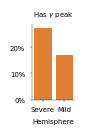

In [23]:
# for cond in ['on', 'off']:
y = 'fm_peak_count'
for cond in ['on']:
    col = f"patient_symptom_dominant_side_BR_{cond}"

    df_mild = df[(df[col] == 'mild side') & (df.cond == cond)]
    df_severe = df[(df[col] == 'severe side') & (df.cond == cond)]

    bands = [
        # 'beta',
            # 'beta_low', 'beta_high',
            # 'gamma_low', 'gamma_mid1',
            'gamma']
    n_col = len(bands)
    fig, axes = plt.subplots(1, n_col, figsize=(.8*n_col, 1.3), sharey=False)
    axes = _axes2d(axes, 1, n_col)
    for i, band in enumerate(bands):
        mild_percentage = (df_mild[f'{band}_{y}'] > 0).sum() / len(df_mild) * 100
        severe_percentage = (df_severe[f'{band}_{y}'] > 0).sum() / len(df_severe) * 100
        ax = axes[0, i]
        kind = 'periodic' if i == 0 else 'periodic2'
        ax.bar(1, severe_percentage, color=cfg.COLOR_DIC['periodic2'])
        ax.bar(2, mild_percentage, color=cfg.COLOR_DIC['periodic2'])
        ax.set_ylabel(None)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax.set_title(f'Has {cfg.BAND_NAMES_GREEK_SHORT[band]} peak')
        ax.set_xticks([1, 2], ['Severe', 'Mild'])
        ax.set_xlabel('Hemisphere')
    # plt.suptitle(cond)
    plt.tight_layout()
    _save_fig(fig, f'{'_'.join(bands)}_{y}_{cond}', close=False, bbox_inches=None,
              transparent=True,
            save_dir=join(SAVE_DIR, 'Figure5', ch_choice))